# MATH 497: Final Project

Remark: 
Please use Jupyter Notebook (Final_Project_yourname.ipynb file) to prepare your final
report, including the output of your code, and submit this on Canvas
by 5pm June 26 Friday EST.

Please summarize your results using Tables, plots and bullet-points
for each problem in a concise, clear and coherent manner.  You are
welcome to organize your presentations using your own style if you
prefer, or you can use the following  as a reference to prepare
your presentation. 

You can also use https://www.tablesgenerator.com/markdown_tables to create your own tables.

=================================================================================================================

## Problem 1 [20%]:  

Consider the following linear system

\begin{equation}\label{matrix}
A\ast u =f,
\end{equation}
or equivalently $u=\arg\min \frac{1}{2} (A* v,v)_F-(f,v)_F$, where $(f,v)_F =\sum\limits_{i,j=1}^{n}f_{i,j}v_{i,j}$ is the Frobenius inner product.
Here $\ast$ represents a convolution with one channel, stride one and zero padding one. The convolution kernel $A$ is given by
$$ 
A=\begin{bmatrix} 0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0 \end{bmatrix},~~
$$
the solution $ u \in \mathbb{R}^{n\times n} $, and the RHS $ f\in \mathbb{R}^{n\times n}$ is given by $f_{i,j}=\dfrac{1}{(n+1)^2}.$


### Tasks:
Set $J=4$, $n=2^J-1$ and the number of iterations $M=100$. Use the gradient descent method and the multigrid method to solve the above problem with a random initial guess $u^0$. Let $u_{GD}$ and $u_{MG}$ denote the solutions obtained by gradient descent and multigrid respectively.
    
* [5%] Plot the surface of solution $u_{GD}$ and $u_{MG}$.

* [10%] Define error $e_{GD}^m = \|A * u^{m}_{GD}- f\|_F=\sqrt{\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{n} |(A * u^{m}_{GD}- f)_{i,j}}|^2 $ for $m=0,1,2,3,...,M$. Similarly, we define the multigrid error $e_{MG}^m$. Plot the errors $e_{GD}^m$ and $e_{MG}^m$ as a function of the iteration $m$ (your x-axis is $m$ and your y-axis is the error). Put both plots together in the same figure.

* [5%] Find the minimal $m_1$ for which $e^{m_1}_{GD} <10^{-5}$ and the minimal $m_2$ for which $e^{m_2}_{MG} <10^{-5}$, and report the computational time for each method. Note that $m_1$ or $m_2$ may be greater than $M=100$, in this case you will have to run more iterations.

### Remark:

Below are examples of using gradient descent and multigrid iterations for M-times 
* #### For gradient descent method with $\eta=\frac{1}{8}$, you need to write a code:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~\text{for    }  i,j = 1: n\\
&~~~~~~~~u_{i,j}^{m} = u_{i,j}^{m-1}-\eta(f_{i,j}-(A\ast u^{m-1})_{i,j})\\
&~~~~\text{endfor}\\
&\text{endfor}
\end{align} 
$$

* #### For multigrid method, we have provided the framework code in F02_MultigridandMgNet.ipynb:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~u^{m} = MG1(u^{m-1},f, J, \nu)\\
&\text{endfor}
\end{align} 
$$

## Results of Problem 1:


### Question 1

### Show your code for the  Question 1

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

def get_mg_init1(A=None, Pi=None, R=None, RT=None):

    A_kernel = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]],dtype=torch.float32)
    Pi_kernel = torch.tensor([[[[0,0,0],[0,0,0],[0,0,0]]]],dtype=torch.float32)
    R_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)
    RT_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)

    if A is not None:
        A.weight = torch.nn.Parameter(A_kernel)
        
    if Pi is not None:
        Pi.weight = torch.nn.Parameter(Pi_kernel)
    
    if R is not None:
        R.weight = torch.nn.Parameter(R_kernel)
    
    if RT is not None:
        RT.weight = torch.nn.Parameter(RT_kernel)
    
    return



##### For MG: setup for prolongation and error calculation #####
RT = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=0, bias=False)
get_mg_init1(None,None,None,RT)
A = nn.Conv2d(1, 1, kernel_size=3,stride=1, padding=1, bias=False)
get_mg_init1(A,None,None,None)



class MgIt(nn.Module):
    def __init__(self, A):
        super().__init__()
        
        get_mg_init(A=A)                       ##### For MG: inilization of A, S #####

        self.A = A

    def forward(self, out):
        u, f = out
        u = u + ((f/8-self.A(u/8)))                                  ##### For MG: u = u + S*(f-A*u) #####
        out = (u, f)
        return out



class MgRestriction1(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        get_mg_init1(A=A,Pi=Pi,R=R)            ##### For MG: inilization of A, Pi, R #####

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

    def forward(self, out):
        u_old, f_old = out
        u = self.Pi(u_old)                              ##### For MG: u = Pi*u_old #####
        f = self.R(f_old-self.A_old(u_old)) + self.A(u) ##### For MG: f = R*(f_old-A_old*u_old) + A*u #####                
        out = (u,f)
        return out


class GD(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f,num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIt(A))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))
            # set attribute. This is equivalent to define
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MG: padding=0 #####  
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=0, bias=False)
                R  = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=0, bias=False)
                
                layers= [MgRestriction1(A_old, A, Pi, R)]
        
    def forward(self, u, f):
        
        out = (u, f) 
                                     ##### For MG: save u^j, j=1,2,...,J #####
        u_list1.append(u)                                      ##### For MG: save u^j, j=1,2,...,J #####
        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
            u, f = out                                        ##### For MG: save u^j, j=1,2,...,J #####
            u_list1.append(u)                                  ##### For MG: save u^j, j=1,2,...,J #####
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        return u

### Question 2

### Show the code for the  Question 2

In [ ]:
#### For MG: inilization of A, S, Pi, R, RT #####
def get_mg_init(A=None, S=None, Pi=None, R=None, RT=None):

    A_kernel = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]],dtype=torch.float32)
    S_kernel = torch.tensor([[[[0,1/64,0],[1/64,12/64,1/64],[0,1/64,0]]]],dtype=torch.float32)
    Pi_kernel = torch.tensor([[[[0,0,0],[0,0,0],[0,0,0]]]],dtype=torch.float32)
    R_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)
    RT_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)

    if A is not None:
        A.weight = torch.nn.Parameter(A_kernel)
    
    if S is not None:
        S.weight = torch.nn.Parameter(S_kernel)
        
    if Pi is not None:
        Pi.weight = torch.nn.Parameter(Pi_kernel)
    
    if R is not None:
        R.weight = torch.nn.Parameter(R_kernel)
    
    if RT is not None:
        RT.weight = torch.nn.Parameter(RT_kernel)
    
    return



##### For MG: setup for prolongation and error calculation #####
RT = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=0, bias=False)
get_mg_init(None,None,None,None,RT)
A = nn.Conv2d(1, 1, kernel_size=3,stride=1, padding=1, bias=False)
get_mg_init(A,None,None,None,None)



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        get_mg_init(A=A,S=S)                       ##### For MG: inilization of A, S #####

        self.A = A
        self.S = S

    def forward(self, out):
        u, f = out
        u = u + (self.S(((f-self.A(u)))))                                   ##### For MG: u = u + S*(f-A*u) #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        get_mg_init(A=A,Pi=Pi,R=R)            ##### For MG: inilization of A, Pi, R #####

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

    def forward(self, out):
        u_old, f_old = out
        u = self.Pi(u_old)                              ##### For MG: u = Pi*u_old #####
        f = self.R(f_old-self.A_old(u_old)) + self.A(u) ##### For MG: f = R*(f_old-A_old*u_old) + A*u #####                
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f,num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))
            # set attribute. This is equivalent to define
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MG: padding=0 #####  
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=0, bias=False)
                R  = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=0, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
    def forward(self, u, f):
        
        out = (u, f) 
                                     ##### For MG: save u^j, j=1,2,...,J #####
        u_list.append(u)                                      ##### For MG: save u^j, j=1,2,...,J #####
        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
            u, f = out                                        ##### For MG: save u^j, j=1,2,...,J #####
            u_list.append(u)                                  ##### For MG: save u^j, j=1,2,...,J #####
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        return u


def plot_solution(J,u,label_name):
    N = 2 ** J -1
    h = 1/2**J
    X = np.arange(h, 1, h)
    Y = np.arange(h, 1, h)
    X, Y = np.meshgrid(X,Y)   # create a mesh
    a = torch.reshape(u, (N, N))
    fig1 = plt.figure()
    ax = Axes3D(fig1)         # plot a 3D surface, (X,Y,u(X,Y))
    ax.plot_surface(X, Y, np.array(a.data), rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.set_title(label_name)

    
def plot_error(M,error1,error2,error3,label_name1,label_name2,label_name3):
    #print(np.linalg.norm((f-self.A(u)).reshape(-1).detach().numpy()))
    plt.figure()
    plt.title('Errors of GDs and Multigrid method vs number of iterations')
    plot1 = plt.plot(error1,'r',label=label_name1)
    plot2 = plt.plot(error2,'b',label=label_name2)
    plot3 = plt.plot(error3,'g',label=label_name3)
    plt.xlabel('Number of iterations')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.legend()
    plt.show()



In [2]:
### graph for both question 1 and question 2

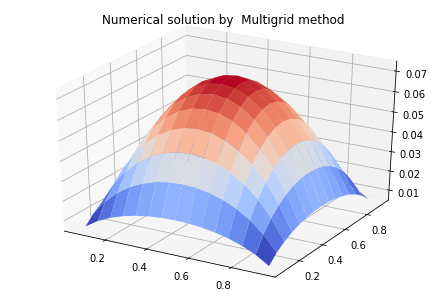

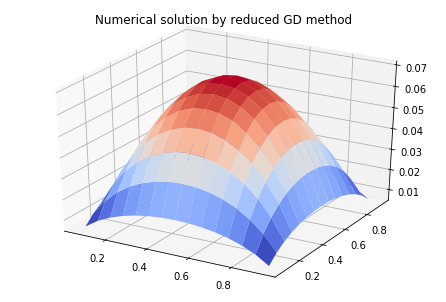

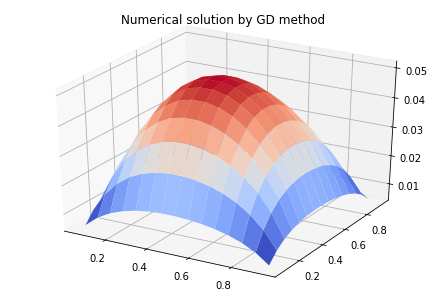

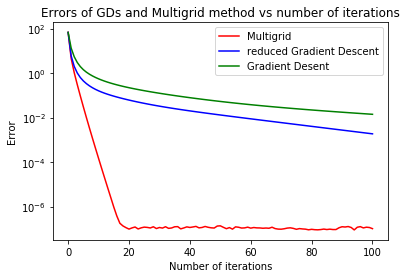

In [56]:
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1 

J = 4 
num_iteration = [2,2,2,2]  # multigrid. change this to [2,0,0,0] gives the gradient descent method
num_iteration2 = [2,0,0,0]
MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)
MG1=MG(num_channel_input, num_iteration2, num_channel_u, num_channel_f, num_classes)
GD0=GD(num_channel_input, num_iteration2, num_channel_u, num_channel_f, num_classes)

##### For MG: PDE setup u=sin(2*pi*x)*sin(2*pi*y) #####

N = 2 ** J -1
h = 1/2**J
u_exact = torch.ones(1,1,N,N)
f = torch.ones(1,1,N,N) / (N+1) **2


##### For MG: Muligrid iteration #####
M = 100
u = torch.randn(1,1,N,N)
u1 = torch.randn(1,1,N,N)
u2 = torch.randn(1,1,N,N)
error1 = [np.linalg.norm((A(u)-f).detach().numpy())]  # calculate the Frobenius Norm of (A*u-f)
error2 = [np.linalg.norm((A(u1)-f).detach().numpy())] 
error3 = [np.linalg.norm((A(u1)-f).detach().numpy())] 

for m in range(M):
    u_list = []                                      # Save u^0,u^1,u^2,u^3...,u^J
    u = MG0(u,f)
    for j in range(J-1,0,-1):
        u_list[j] += RT(u_list[j+1])
    u = u_list[1]
    error1.append(np.linalg.norm((A(u)-f).detach().numpy())) # calculate the Frobenius Norm of (A*u-f)

for m in range(M):
    u_list = []                                      # Save u^0,u^1,u^2,u^3...,u^J
    u1 = MG1(u1,f)
    for j in range(J-1,0,-1):
        u_list[j] += RT(u_list[j+1])
    u1 = u_list[1]
    error2.append(np.linalg.norm((A(u1)-f).detach().numpy())) # calculate the Frobenius Norm of (A*u-f)
    
for m in range(M):
    u_list1 = []                                      # Save u^0,u^1,u^2,u^3...,u^J
    u2 = GD0(u2,f)
    for j in range(J-1,0,-1):
        u_list1[j] += RT(u_list1[j+1])
    u2 = u_list1[1]
    error3.append(np.linalg.norm((A(u2)-f).detach().numpy())) # calculate the Frobenius Norm of (A*u-f)




##### Lian added for MG: Plot results #####
plot_solution(J,u,'Numerical solution by  Multigrid method')
plot_solution(J,u1,'Numerical solution by reduced GD method')
plot_solution(J,u2,'Numerical solution by GD method')

plot_error(M,error1,error2,error3,"Multigrid",'reduced Gradient Descent','Gradient Desent')

### Question 3

### The following table shows the results of the Question 3:

| Method           | $\nu$ or $\eta$ | #iterations | computational time |
|:-----------------|:-----------|:--------------------|:-------------------|
| Gradient descent |    1/8        |        350             |    0.80289                |
| Multigrid        |    the given matrix        |        13             |         0.04426           |
|                  |            |                     |                    |

### Discussions or Conclusions

#### *  don't know why, but it looks like the reduced GD method performs a little bit better than the GD method
#### *  multigrid method performs much better than the other two method

=================================================================================================================

## Problem 2 [50%]: 

Use SGD with momentum and weight decay to train MgNet on the Cifar10 dataset. Use 120 epochs, set the initial learning rate to 0.1, momentum to 0.9, weight decay to 0.0005, and divide the learning rate by 10 every 30 epochs. (The code to do this has been provided.) Let $b_i$ denote the test accuracy of the model after $i$ epochs, and let $b^*$ = $\max_i(b_i)$ be the best test accuracy attained during training.


### Tasks:
   * [30%] Train MgNet with the following three sets of hyper-parameters (As a reminder, the hyper-parameters of MgNet are $\nu$, the number of iterations of each layer, $c_u$, the number of channels for $u$, and $c_f$, the number of channels for $f$.):
 
    (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.
    
    (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.

    (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, try to improve the test accuracy by implementing MgNet with $S^{l,i}$, which means different iterations in the same layer do not share the same $S^{l}$. 
  
  
   * For each numerical experiment above, print the results with the following format:

       "Epoch: i, Learning rate: lr$_i$, Training accuracy: $a_i$, Test accuracy: $b_i$"

        where $i=1,2,3,...$ means the $i$-th epoch,  $a_i$ and $b_i$ are the training accuracy and test accuracy computed at the end of $i$-th epoch, and lr$_i$ is the learning rate of $i$-th epoch.
    
    
   * [10%] For each numerical experiment above, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. An example plot is shown in the next cell.
   
   
   * [10%] Calculate the number of parameters that each of the above models has. Discuss why the number of parameters is different (or the same) for each of the models.
       

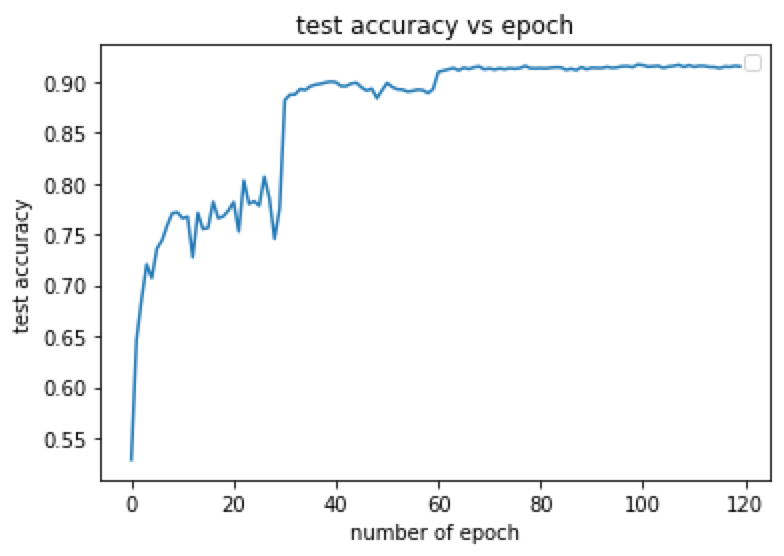

In [ ]:
from IPython.display import Image
Image(filename='plot_sample_code.png')


In [ ]:
# You can calculate the number of parameters of my_model by:
model_size = sum(param.numel() for param in my_model.parameters())


## Results of Problem 2:


### For (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.

### Show your code 
### Show the print and plots 

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10   
num_iteration = [1,1,1,1]

# Step 1: Define a model
my_model = MgNet(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



blist1=[]
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    
    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    
    blist1.append(test_accuracy)
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy))           

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, the training accuracy: 0.47424, the test accuracy: 0.4837
Epoch: 2, learning rate: 0.1, the training accuracy: 0.64758, the test accuracy: 0.6346
Epoch: 3, learning rate: 0.1, the training accuracy: 0.68124, the test accuracy: 0.6775
Epoch: 4, learning rate: 0.1, the training accuracy: 0.71112, the test accuracy: 0.7054
Epoch: 5, learning rate: 0.1, the training accuracy: 0.7042, the test accuracy: 0.6831
Epoch: 6, learning rate: 0.1, the training accuracy: 0.75344, the test accuracy: 0.7528
Epoch: 7, learning rate: 0.1, the training accuracy: 0.72958, the test accuracy: 0.7173
Epoch: 8, learning rate: 0.1, the training accuracy: 0.74974, the test accuracy: 0.7366
Epoch: 9, learning rate: 0.1, the training accuracy: 0.77976, the test accuracy: 0.7667
Epoch: 10, learning rate: 0.1, the training accuracy: 0.78092, the test accuracy: 0.7645
Epoch: 11, learning rate: 0.1, the training 

### For (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.

### Show your code 
### Show the print and plots 

In [ ]:


num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model1 = MgNet(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model1 = my_model1.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model1.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

blist2=[]
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model1.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model1(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model1.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model1(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    
    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model1(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    
    blist2.append(test_accuracy)
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy))           


Epoch: 1, learning rate: 0.1, the training accuracy: 0.43298, the test accuracy: 0.4273
Epoch: 2, learning rate: 0.1, the training accuracy: 0.55996, the test accuracy: 0.5749
Epoch: 3, learning rate: 0.1, the training accuracy: 0.6254, the test accuracy: 0.6218
Epoch: 4, learning rate: 0.1, the training accuracy: 0.65682, the test accuracy: 0.6491
Epoch: 5, learning rate: 0.1, the training accuracy: 0.6947, the test accuracy: 0.6905
Epoch: 6, learning rate: 0.1, the training accuracy: 0.71414, the test accuracy: 0.7011
Epoch: 7, learning rate: 0.1, the training accuracy: 0.6473, the test accuracy: 0.6322
Epoch: 8, learning rate: 0.1, the training accuracy: 0.75146, the test accuracy: 0.7477
Epoch: 9, learning rate: 0.1, the training accuracy: 0.79606, the test accuracy: 0.7818
Epoch: 10, learning rate: 0.1, the training accuracy: 0.74302, the test accuracy: 0.7296
Epoch: 11, learning rate: 0.1, the training accuracy: 0.78598, the test accuracy: 0.7705
Epoch: 12, learning rate: 0.1, th

### For (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, MgNet with $S^{l,i}$

### Show your code 
### Show the print and plots 

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

def get_mg_init(A=None, S=None, Pi=None, R=None, RT=None):

    A_kernel = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]],dtype=torch.float32)
    S_kernel = torch.tensor([[[[0,1/64,0],[1/64,12/64,1/64],[0,1/64,0]]]],dtype=torch.float32)
    Pi_kernel = torch.tensor([[[[0,0,0],[0,0,0],[0,0,0]]]],dtype=torch.float32)
    R_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)
    RT_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)

    if A is not None:
        A.weight = torch.nn.Parameter(A_kernel)
    
    if S is not None:
        S.weight = torch.nn.Parameter(S_kernel)
        
    if Pi is not None:
        Pi.weight = torch.nn.Parameter(Pi_kernel)
    
    if R is not None:
        R.weight = torch.nn.Parameter(R_kernel)
    
    if RT is not None:
        RT.weight = torch.nn.Parameter(RT_kernel)
    
    return



##### For MG: setup for prolongation and error calculation #####
RT = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=0, bias=False)
get_mg_init(None,None,None,None,RT)
A = nn.Conv2d(1, 1, kernel_size=3,stride=1, padding=1, bias=False)
get_mg_init(A,None,None,None,None)

class MgIte1(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction1(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MgNet1(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte1(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))
            # set attribute. This is equivalent to define
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            if l < len(num_iteration)-1:
                A_old = A
            
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                
                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                layers= [MgRestriction1(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
       
        
        out = (u, f) 

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
            u, f = out                                 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u     

Use GPU? True


In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10     
num_iteration = [2,2,2,2]


# Step 1: Define a model
my_model2 = MgNet1(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model2 = my_model2.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model2.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)


blist3=[]
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model2.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model2(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model2.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model2(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    
    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model2(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    
    blist3.append(test_accuracy)
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy))   
 

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, the training accuracy: 0.46694, the test accuracy: 0.4698
Epoch: 2, learning rate: 0.1, the training accuracy: 0.5616, the test accuracy: 0.5843
Epoch: 3, learning rate: 0.1, the training accuracy: 0.64614, the test accuracy: 0.6422
Epoch: 4, learning rate: 0.1, the training accuracy: 0.68564, the test accuracy: 0.6746
Epoch: 5, learning rate: 0.1, the training accuracy: 0.69154, the test accuracy: 0.6842
Epoch: 6, learning rate: 0.1, the training accuracy: 0.76046, the test accuracy: 0.7579
Epoch: 7, learning rate: 0.1, the training accuracy: 0.73026, the test accuracy: 0.7192
Epoch: 8, learning rate: 0.1, the training accuracy: 0.79692, the test accuracy: 0.7886
Epoch: 9, learning rate: 0.1, the training accuracy: 0.78092, the test accuracy: 0.7699
Epoch: 10, learning rate: 0.1, the training accuracy: 0.78942, the test accuracy: 0.7804
Epoch: 11, learning rate: 0.1, the training 

In [ ]:
### * plots for all 3 cases

for (1) we have b*:0.9163, for (2) we have b*:0.9263, for (3) we have b*:0.9278


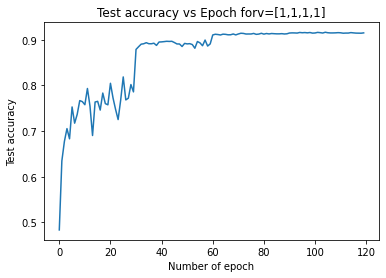

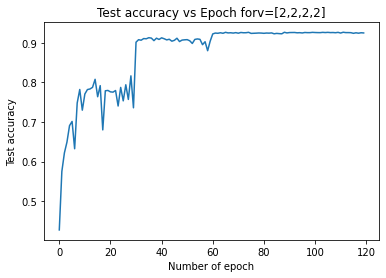

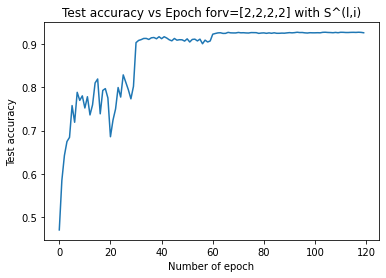

In [ ]:
bstar1 = max(blist1)
bstar2 = max(blist2)
bstar3 = max(blist3)
print('for (1) we have b*:{}, for (2) we have b*:{}, for (3) we have b*:{}'.format(bstar1,bstar2,bstar3))

def plot_graph(blist,vstring):
    plt.figure()
    plt.title('Test accuracy vs Epoch for'+vstring)
    plot = plt.plot(blist)
    plt.xlabel('Number of epoch')
    plt.ylabel('Test accuracy')
    plt.show()

plot_graph(blist1,'v=[1,1,1,1]')
plot_graph(blist2,'v=[2,2,2,2]')
plot_graph(blist3,'v=[2,2,2,2] with S^(l,i)')

### Summary 

|      Model            | $c_u, c_f$ | $\nu$      | test accuracy $b^*$ |computational time | #parameters |
|:----------------------|:-----------|:-----------|:--------------------|:------------------|:------------|
| MgNet with $S^{l}$    |     64       |  [1,1,1,1] |       0.9163              |                   |         520394    |
| MgNet with $S^{l}$    |      64      |  [2,2,2,2] |          0.9263           |                   |      521418       |
| MgNet with $S^{l,i}$  |      64      |  [2,2,2,2] |             0.9278        |                   |      668874       |

### Discussions or Conclusions

#### *  without using the S^(i,l) strategy, v=[1,1,1,1] and v=[2,2,2,2] has different num of parameters simply because there are different numbers of iterations for each layer which means that the Mgnet and Restriction func will be called more times and using more parameters as input when using S^(i,l) strategy the number of parameters increases even for the same numbers of iterations at each layer that is because we have different S in each iterations which increases the numbers of parameters
#### * using S^{l,i} indeed increases the test accuracy since for the some lr, we can observe a constantly higher accuracy than the case without using the strategy by fixing the same v.

=================================================================================================================

## Problem 3 [25 %]:

Try to improve the MgNet Accuracy by increasing the number of channels. (We use the same notation as in the previous problem.) Double the number of channels to $c_u=c_f=128$ and try different $\nu$ to maximize the test accuracy.

### Tasks:
   * [20%] Report $b^{*}$, $\nu$ and the number of parameters of your model for each of the experiments you run.
   * [5%] For the best experiment, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. (Same as for the previous problem.)

In [ ]:
# You can calculate the number of parameters of my_model by:
model_size = sum(param.numel() for param in my_model.parameters())


## Results of Problem 3:


### Summary 

|                  | $c_u, c_f$ | $\nu$      | test accuracy $b^*$ |computational time | #parameters |
|:-----------------|:-----------|:-----------|:--------------------|:------------------|:------------|
|                  |       128     |     [1,1,1,1]       |            0.9271         |                   |       2072970      |
|                  |     128       |     [2,2,2,2]       |           0.9407          |                   |      2664842       |
|                  |     128       |    [1,1,2,2]        |        0.9327             |                 |    2368906         |

### Discussions or Conclusions

#### *  I think maybe the test accuracy b* depends on the num of parameters and more iterations on the start layers increases b* (this guess is from comparing v=[1,1,2,2] and [2,2,1,1] . Suppose to make more comparations to make conclusion. Don't have time
#### * if my assumption is right. Then if limit num_iterations to 1 or 2 for each layer then v=[2,2,2,2] is indeed the best one

In [ ]:
### Also test another set for c_f=c_u=128, v=[2,2,1,1] and b* is 93.78%. Num of parameters is 2368906

### For the best experiment, plot the test accuracy against the epoch count

In [ ]:
# v=[2,2,2,2] is the best one with 0.9407 test accuracy for 120 epoch, lr divided by 10 each 30 epoch
# there is something happend for my program so in order to plot the graph, I did another run for v=[2,2,2,2]
# with total 80 epoch and lr divided by 10 each 20 epoch, which get 0.9401 for b* (I don't know why, but the code ask me to rerun my code
# in order to plot the graph which I don't have enough time)


In [ ]:
print('For v=[2,2,2,2]')
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 20)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 90
lr = 0.1

num_channel_input = 3
num_channel_u = 128
num_channel_f = 128
num_classes = 10     
num_iteration = [2,2,2,2]


# Step 1: Define a model
my_model4 = MgNet1(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model4 = my_model4.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model4.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)


blist5=[]
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model4.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model4(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters

  # Training accuracy
    my_model4.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model4(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    
    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model4(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    
    blist5.append(test_accuracy)
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy))
bstar4=max(blist5)
model_size4 = sum(param.numel() for param in my_model4.parameters())
print('b* is {} and parameter nums is {} for v=[2,2,2,2]'.format(bstar4,model_size4))

For v=[2,2,2,2]
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, the training accuracy: 0.42762, the test accuracy: 0.4338
Epoch: 2, learning rate: 0.1, the training accuracy: 0.56496, the test accuracy: 0.556
Epoch: 3, learning rate: 0.1, the training accuracy: 0.6248, the test accuracy: 0.6208
Epoch: 4, learning rate: 0.1, the training accuracy: 0.65876, the test accuracy: 0.648
Epoch: 5, learning rate: 0.1, the training accuracy: 0.72592, the test accuracy: 0.7101
Epoch: 6, learning rate: 0.1, the training accuracy: 0.68262, the test accuracy: 0.6579
Epoch: 7, learning rate: 0.1, the training accuracy: 0.81408, the test accuracy: 0.8052
Epoch: 8, learning rate: 0.1, the training accuracy: 0.75982, the test accuracy: 0.7413
Epoch: 9, learning rate: 0.1, the training accuracy: 0.75118, the test accuracy: 0.7374
Epoch: 10, learning rate: 0.1, the training accuracy: 0.77262, the test accuracy: 0.7593
Epoch: 11, learning rate: 0.1,

KeyboardInterrupt: ignored

In [ ]:
#don't have time to finish the last 10 epoch, but reaching 0.94 is enough to see v=[2,2,2,2] is better than other v

after testing four cases where v=[1,1,1,1];[2,2,2,2];[1,1,2,2];[2,2,1,1], it is reasonable to conclude that v=[2,2,2,2] is the best one with b* (b* for 90 epoch, lr divided by 10 each 20 epoch) 0.94


cannot be plotted since I change my function Mgnet1 once and need to rerun the code to get a reference for blist5 which do not have time to do it, sorry about this


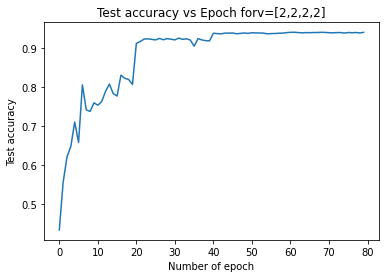

In [ ]:
print("after testing four cases where v=[1,1,1,1];[2,2,2,2];[1,1,2,2];[2,2,1,1], it is reasonable to conclude that v=[2,2,2,2] is the best one with b* (b* for 90 epoch, lr divided by 10 each 20 epoch)",0.94)
#see the code for the 90 epoch bstar
#b* for 120 epoch is 0.9407
print('\n')

def plot_graph(blist,vstring):
    plt.figure()
    plt.title('Test accuracy vs Epoch for'+vstring)
    plot = plt.plot(blist)
    plt.xlabel('Number of epoch')
    plt.ylabel('Test accuracy')
    plt.show()

print('cannot be plotted since I change my function Mgnet1 once and need to rerun the code to get a reference for blist5 which do not have time to do it, sorry about this')
plot_graph(blist5,'v=[2,2,2,2]')

=================================================================================================================

## Problem 4 [5%]:

Continue testing larger MgNet models (i.e. increase the number of channels) to maximize the test accuracy. (Again, we use the same notation as in problem 2.)

### Tasks:    
    
+  [5%] Try different training strategies and MgNet architectures with the goal of achieving $b^*>$ 95%. Hint: you can tune the number of epochs, the learning rate schedule, $c_u$, $c_f$, $\nu$, try different $S^{l,i}$ in the same layer $l$, etc...

## Results of Problem 4:


### Summary 

|    | $c_u, c_f$ | $\nu$     | test accuracy $b^*$ |computational time | #parameters|other parameters you tuned|
|:---|:-----------|:----------|:--------------------|:------------------|:-----------|:-------------------------|
|    |      256      |    [2,2,2,2]       |                     |                   |            |                          |
|    |            |           |                     |                   |            |                          |
|    |            |           |                     |                   |            |                          |


### Discussions or Conclusions

#### *  do not have enough time (it stops while running) to finish this iterations, but I think it will work for v=[2,2,2,2] and c_f=c_u=128 to achieve at least higher then 94.07% since we reach 93.59 at lr=0.01 for epoch around 40 for c_u=c_f=256 which is far more then what can be achieve by previous cases
#### * it is reasonable to expect that increase c_u and c_f to 256, 512 and other powers of 2 will indeed lead us to test accuracy of 0.95

=================================================================================================================